# Autoencoder + Transformer Hybrid Model with SHAP Analysis

In [1]:
# Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap

c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Data Loading

In [2]:
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

## Step 2: Data Preprocessing

In [3]:
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize numerical features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Step 3: Define Autoencoder + Transformer Hybrid Model

In [4]:
# Autoencoder Component
def build_autoencoder(input_dim):
    inputs = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(128, activation="relu")(inputs)
    encoded = layers.Dense(64, activation="relu")(encoded)
    encoded = layers.Dense(32, activation="relu")(encoded)
    decoded = layers.Dense(64, activation="relu")(encoded)
    decoded = layers.Dense(128, activation="relu")(decoded)
    outputs = layers.Dense(input_dim, activation="sigmoid")(decoded)
    autoencoder = keras.Model(inputs, outputs, name="autoencoder")
    encoder = keras.Model(inputs, encoded, name="encoder")
    return autoencoder, encoder

# Transformer Component
def build_transformer(input_shape):
    inputs = keras.Input(shape=(input_shape,))
    x = tf.expand_dims(inputs, axis=1)  # Add sequence dimension
    x = layers.Dense(32, activation="relu")(x)
    for _ in range(2):
        x1 = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x1 = layers.Add()([x, x1])
        x1 = layers.LayerNormalization()(x1)
        x2 = layers.Dense(32, activation="relu")(x1)
        x2 = layers.Dropout(0.3)(x2)
        x = layers.Add()([x1, x2])
        x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="transformer")
    return model

# Combine Autoencoder and Transformer
input_dim = x_train.shape[1]
autoencoder, encoder = build_autoencoder(input_dim)
transformer = build_transformer(32)  # Latent dimension from encoder

# Compile Autoencoder
autoencoder.compile(optimizer="adam", loss="mse")
print("Training Autoencoder...")
autoencoder.fit(x_train, x_train, epochs=20, batch_size=64, validation_data=(x_val, x_val))

# Encode Features
encoded_x_train = encoder.predict(x_train)
encoded_x_val = encoder.predict(x_val)
encoded_x_test = encoder.predict(X_test)

# Compile Transformer
transformer.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print("Training Transformer...")
history = transformer.fit(encoded_x_train, y_train, epochs=20, batch_size=64, validation_data=(encoded_x_val, y_val))

Training Autoencoder...
Epoch 1/20
1575/1575 [==============================] - 8s 5ms/step - loss: 0.7453 - val_loss: 0.7088
Epoch 2/20
1575/1575 [==============================] - 7s 5ms/step - loss: 0.7164 - val_loss: 0.6978
Epoch 3/20
1575/1575 [==============================] - 7s 4ms/step - loss: 0.7125 - val_loss: 0.6961
Epoch 4/20
1575/1575 [==============================] - 7s 4ms/step - loss: 0.7097 - val_loss: 0.6922
Epoch 5/20
1575/1575 [==============================] - 6s 4ms/step - loss: 0.7074 - val_loss: 0.6919
Epoch 6/20
1575/1575 [==============================] - 7s 4ms/step - loss: 0.7073 - val_loss: 0.6919
Epoch 7/20
1575/1575 [==============================] - 7s 4ms/step - loss: 0.7071 - val_loss: 0.6913
Epoch 8/20
1575/1575 [==============================] - 7s 4ms/step - loss: 0.7057 - val_loss: 0.6903
Epoch 9/20
1575/1575 [==============================] - 7s 4ms/step - loss: 0.7049 - val_loss: 0.6869
Epoch 10/20
1575/1575 [==============================] - 7

## Step 4: Evaluate the Model

In [5]:
# Evaluate on the test set
test_loss, test_accuracy = transformer.evaluate(encoded_x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

705/705 [==============================] - 4s 6ms/step - loss: 1.5266 - accuracy: 0.7754
Test Loss: 1.5266056060791016, Test Accuracy: 0.7754169702529907


## Step 5: Visualizations

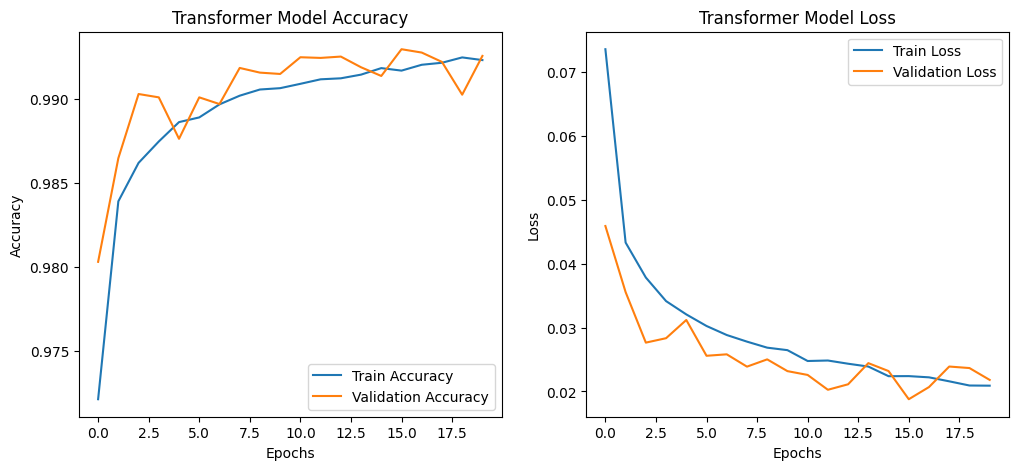

In [6]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Transformer Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Transformer Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

705/705 [==============================] - 4s 5ms/step


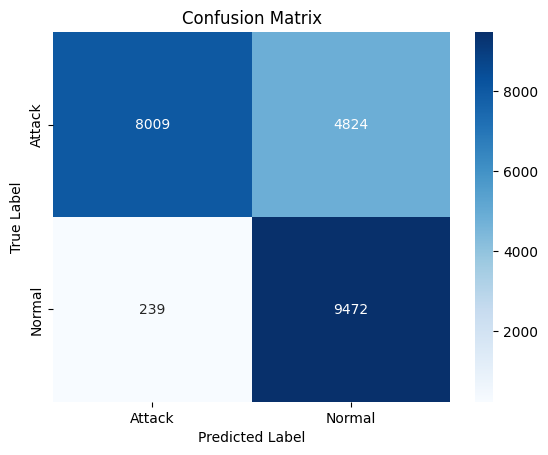

              precision    recall  f1-score   support

      Attack       0.97      0.62      0.76     12833
      Normal       0.66      0.98      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.77     22544
weighted avg       0.84      0.78      0.77     22544



In [7]:
# Confusion Matrix
y_pred = (transformer.predict(encoded_x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

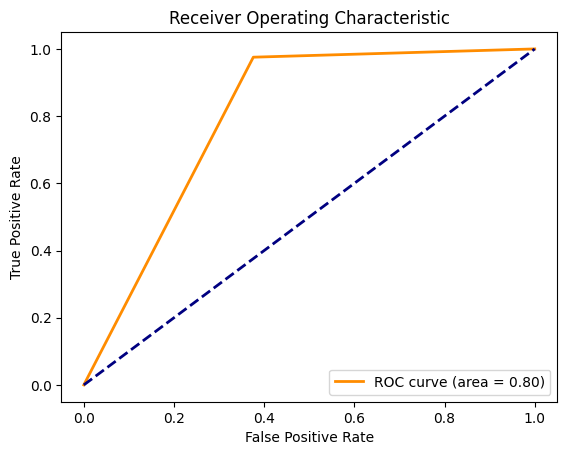

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Step 6: SHAP Analysis

In [9]:
# Explain predictions with SHAP
explainer = shap.KernelExplainer(transformer.predict, encoded_x_test[:100])  # Use a subset for SHAP due to compute constraints
shap_values = explainer.shap_values(encoded_x_test[:100])

# Summary Plot
shap.summary_plot(shap_values[0], encoded_x_test[:100], feature_names=train.columns[:-1])

# Force Plot (First Instance)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], encoded_x_test[:1], feature_names=train.columns[:-1])

# Feature Importance Plot
shap.summary_plot(shap_values, encoded_x_test[:100], plot_type="bar", feature_names=train.columns[:-1])

4/4 [==============================] - 0s 5ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

6594/6594 [==============================] - 33s 5ms/step


  1%|          | 1/100 [00:39<1:05:56, 39.97s/it]

6594/6594 [==============================] - 34s 5ms/step


  2%|▏         | 2/100 [01:19<1:04:52, 39.72s/it]

6594/6594 [==============================] - 35s 5ms/step


  3%|▎         | 3/100 [01:59<1:04:38, 39.98s/it]

6594/6594 [==============================] - 37s 6ms/step


  4%|▍         | 4/100 [02:39<1:04:02, 40.03s/it]

6594/6594 [==============================] - 35s 5ms/step


  5%|▌         | 5/100 [03:17<1:01:46, 39.02s/it]

6594/6594 [==============================] - 34s 5ms/step


  6%|▌         | 6/100 [03:55<1:00:40, 38.72s/it]

6594/6594 [==============================] - 34s 5ms/step


  7%|▋         | 7/100 [04:34<1:00:05, 38.77s/it]

6594/6594 [==============================] - 34s 5ms/step


  8%|▊         | 8/100 [05:13<59:55, 39.08s/it]  

6594/6594 [==============================] - 34s 5ms/step


  9%|▉         | 9/100 [05:53<59:30, 39.23s/it]

6594/6594 [==============================] - 34s 5ms/step


 10%|█         | 10/100 [06:32<58:55, 39.28s/it]

6594/6594 [==============================] - 34s 5ms/step


 11%|█         | 11/100 [07:12<58:22, 39.35s/it]

6594/6594 [==============================] - 34s 5ms/step


 12%|█▏        | 12/100 [07:52<57:53, 39.47s/it]

6594/6594 [==============================] - 34s 5ms/step


 13%|█▎        | 13/100 [08:31<57:11, 39.44s/it]

6594/6594 [==============================] - 34s 5ms/step


 14%|█▍        | 14/100 [09:10<56:27, 39.39s/it]

6594/6594 [==============================] - 34s 5ms/step


 15%|█▌        | 15/100 [09:49<55:43, 39.33s/it]

6594/6594 [==============================] - 34s 5ms/step


 16%|█▌        | 16/100 [10:29<55:10, 39.41s/it]

6594/6594 [==============================] - 34s 5ms/step


 17%|█▋        | 17/100 [11:09<54:43, 39.56s/it]

6594/6594 [==============================] - 34s 5ms/step


 18%|█▊        | 18/100 [11:49<54:05, 39.58s/it]

6594/6594 [==============================] - 31883s 5s/step


 19%|█▉        | 19/100 [9:03:17<216:06:46, 9605.02s/it]

6594/6594 [==============================] - 35s 5ms/step


 20%|██        | 20/100 [9:03:56<149:37:32, 6733.16s/it]

6594/6594 [==============================] - 34s 5ms/step


 21%|██        | 21/100 [9:04:36<103:39:48, 4723.91s/it]

6594/6594 [==============================] - 7183s 1s/step


 22%|██▏       | 22/100 [11:04:29<118:24:19, 5464.87s/it]

6594/6594 [==============================] - 100s 15ms/step


 23%|██▎       | 23/100 [11:06:20<82:31:39, 3858.43s/it] 

6594/6594 [==============================] - 104s 16ms/step


 24%|██▍       | 24/100 [11:08:15<57:44:24, 2735.05s/it]

4278/6594 [==================>...........] - ETA: 23:28

 24%|██▍       | 24/100 [11:51:37<37:33:27, 1779.05s/it]


KeyboardInterrupt: 